In [1]:
import numpy as np 
import torch 
import torch.nn as nn
from skimage.data import shepp_logan_phantom
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from skimage.transform import resize, radon, iradon
from scipy.optimize import curve_fit
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

In [2]:
#Setup 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nxd = 182
theta = np.linspace(0., 180., max(nxd, 180), endpoint=False)

In [3]:
#Function to add Poisson noise to the sinogram

def add_poisson(sino, scale):
    
    scaled_sino = sino * scale

    scaled_sino = np.clip(scaled_sino, 0, 1e6)

    #Generate Posson distributed random values with mean = scaled_sino
    noisy = np.random.poisson(scaled_sino)

    return noisy / scale

def mlem_reco(sino, azi_angles, num_its: int):
    #Define reconstructed image
    image_size = sino.shape[0]   #define image reco size based on sinogram height
    mlem_rec = np.ones((image_size, image_size))

    #Compute sensitivity image (A^T 1)
    sens_image = iradon(
        np.ones_like(sino),
        azi_angles,
        circle=True,
        filter_name=None,
        output_size=image_size
    )

    for iter in range(num_its):  
        fp = radon(mlem_rec, azi_angles, circle=True) #Forward projection of mlem_rec at iteration k (A x^k)
        #print(fp.shape)

        ratio = sino / (fp + 0.000001) #ratio sinogram, tells you how off the estimate was
        correction = iradon(ratio, azi_angles, circle=True , filter_name=None, output_size=image_size) / (sens_image + 0.000001) # No filter because we are just getting the transpose A^T

        mlem_rec = mlem_rec * correction

    return mlem_rec

def crop_to_square(img):
    h, w = img.shape
    min_dim = min(h, w)
    top = (h - min_dim) // 2
    left = (w - min_dim) // 2
    
    return img[top:top + min_dim, left:left + min_dim]

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp ( - (x - mean)**2 / (2 * standard_deviation **2))

def scal_func(n, av_counts): 
    r = n/100
    x = 1 / ( (r**2)*(av_counts) )
    return x

In [4]:
#Reading in CT scan Data 
import nibabel as nib
import random

#Parameters
z_half_window = 10
t_half_window = 8
#rel_noise = [None, 1, 3, 5, 10]

#Load files
paths = [
    "LondonPride_000101_dynPET.img",
    "LondonPride_000102_dynPET.img",
    "LondonPride_000103_dynPET.img",
    "LondonPride_000104_dynPET.img",
    "LondonPride_000105_dynPET.img",
]

images = []
sinograms = []

for p in paths:

    img = nib.load(p)
    pet_data = img.get_fdata(dtype=np.float32)

    # Get full Z range and calculate start and end
    total_slices = pet_data.shape[2]
    center = total_slices // 2
    z_start = center - z_half_window
    z_end = center + z_half_window

    # Just to be safe:
    z_start = max(0, z_start)
    z_end = min(total_slices, z_end)

    #print(z_start, z_end)

    # Get full t range and calculate start and end
    total_slices = pet_data.shape[3]
    center = total_slices // 2
    t_start = center - t_half_window
    t_end = center + t_half_window

    # Just to be safe:
    t_start = max(0, t_start)
    t_end = min(total_slices, t_end)

    #print(t_start, t_end)

    for t in range(t_start, t_end): #Time framse
        for z in range(z_start, z_end): #Central 100 slices

            slice_img = pet_data[:, :, z, t]

            image_cropped = crop_to_square(slice_img)
            image_resized = resize(image_cropped, (nxd, nxd), anti_aliasing=True)

            # Normalise
            image_resized = image_resized.astype(np.float32)
            image_resized /= np.max(image_resized) + 1e-8   # avoid divide-by-zero

            images.append(image_resized)
        
            # Generate sinogram
            sino_clean = radon(image_resized, theta=theta, circle=True)
            sino_clean /= np.max(sino_clean) + 1e-8   # normalise sinogram

            #noise_choice = random.choice(rel_noise)
            noise_choice = None

            if noise_choice is None:
                sinograms.append(sino_clean)
            else:
                counts_bin = sino_clean.ravel()
                bin_heights, bin_edges = np.histogram(counts_bin, bins=50)
                bin_centres = bin_edges[:-1] + np.diff(bin_edges) / 2

                # 1) Clean/weight the data (avoid zeros/NaNs and use Poisson weights)
                mask = np.isfinite(bin_heights) & np.isfinite(bin_centres) & (bin_heights > 0)
                x = bin_centres[mask]
                y = bin_heights[mask]
                sigma_w = np.sqrt(y)            # Poisson stdev
                sigma_w[sigma_w == 0] = 1.0     # safety

                # 2) Data-driven initial guesses
                A0 = y.max()
                # weighted mean & std as starting points
                mu0 = np.average(x, weights=y)
                sigma0 = np.sqrt(np.average((x - mu0)**2, weights=y))
                # fallback if sigma0 is tiny/NaN
                if not np.isfinite(sigma0) or sigma0 <= 0:
                    sigma0 = (x.max() - x.min())/6.0

                p0 = [A0, mu0, sigma0]

                # 3) Constrain parameters to sensible ranges and allow more iterations
                lower = [0, x.min(), 1e-9]      # A>=0, mu in data range, sigma>0
                upper = [np.inf, x.max(), np.inf]

                popt, pcov = curve_fit(
                    gaussian, x, y,
                    p0=p0,
                    sigma=sigma_w,
                    absolute_sigma=True,   # interpret sigma as true stdevs
                    bounds=(lower, upper), # enables robust 'trf' solver internally
                    maxfev=20000           # more function evaluations
                    )

                av_counts = popt[0]
                #print(av_counts)
                scale = scal_func(noise_choice, av_counts)
                sino_noisy = add_poisson(sino_clean, scale)
                sinograms.append(sino_noisy)

/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


In [5]:
# Convert to NumPy arrays
images = np.array(images)
sinograms = np.array(sinograms)

print(len(images))
print(len(sinograms))

1600
1600


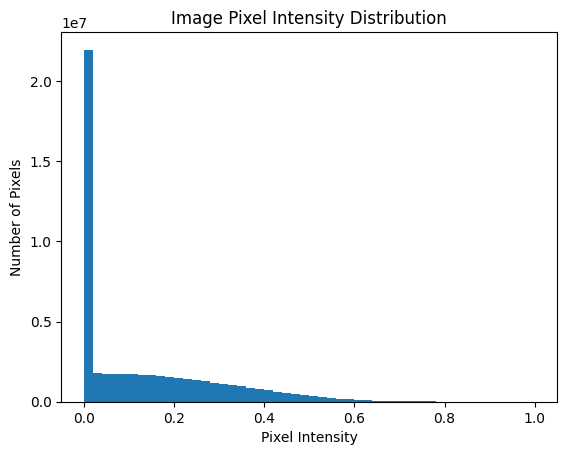

In [6]:
plt.hist(images.ravel(), bins=50)
plt.xlabel("Pixel Intensity")
plt.ylabel("Number of Pixels")
plt.title("Image Pixel Intensity Distribution")
plt.show()

In [7]:
train_x, temp_x, train_y, temp_y = train_test_split(sinograms, images,  test_size=0.3, random_state=42)
val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y,  test_size=0.01, random_state=42)

class MLEMDataset(Dataset):
    def __init__(self, sinograms, images):
        self.sinograms = sinograms
        self.images = images

    def __len__(self):
        return len(self.sinograms)
    
    def __getitem__(self, idx):
        mlem_im = torch.from_numpy(self.sinograms[idx]).float()
        img = torch.from_numpy(self.images[idx]).float()
        return mlem_im, img
    
train_dataset = MLEMDataset(train_x, train_y)
val_dataset = MLEMDataset(val_x, val_y)
test_dataset = MLEMDataset(test_x, test_y)
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10)
test_loader = DataLoader(test_dataset, batch_size=10)

Train: 1120, Val: 475, Test: 5


In [21]:
from pytorch_msssim import ssim as ssim_torch

#Defining the convolutional autoencoder that takes sinogram as input and produces an image

class DeepPET(nn.Module):
    def __init__(self, out_hw=(nxd,nxd)):
        super().__init__()
        self.out_hw = out_hw

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(32, momentum=0.2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(64, momentum=0.2), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(128, momentum=0.2), nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(256, momentum=0.2), nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(512, momentum=0.2), nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(1024, momentum=0.2), nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(512, momentum=0.2), nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(256, momentum=0.2), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(128, momentum=0.2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(64, momentum=0.2),  nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(32, momentum=0.2), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(1, momentum=0.2), nn.ReLU(),
            nn.Upsample(size=out_hw, mode='bilinear', align_corners=False)  # force (nxd, nxd)
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)   
        return x
    

class SSIM_MSE_Loss(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        mse_loss = self.mse(pred, target)
        return self.alpha * mse_loss + (1 - self.alpha) * (1 - ssim_torch(pred, target, data_range=1.0, size_average=True))
    
    def components(self, pred, target):
        #Return individual MSE and SSIM components for logging
        mse_val = self.mse(pred, target).item()
        ssim_val = 1 - ssim_torch(pred, target, data_range=1.0, size_average=True).item()
        return mse_val, ssim_val



In [26]:
from tqdm import tqdm

alphas = [0.2]

model = DeepPET().to(device)

for alpha in alphas:
    #loss_function = SSIM_MSE_Loss(alpha=alpha)
    loss_function = nn.MSELoss()
    optim = torch.optim.SGD(model.parameters())

    train_loss_history, val_loss_history = [], []
    train_mse_history, val_mse_history = [], []
    train_ssim_history, val_ssim_history = [], []

    epochs = 200

    for epoch in range(epochs):

        model.train()
        running_train_loss, train_mse, train_ssim = 0, 0, 0

        for sinogram, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):

            # Expect [B, 1, H, W]; add channel dim if missing
            if sinogram.ndim == 3:  # [B, H, W]
                sinogram = sinogram.unsqueeze(1)
            if target.ndim == 3:
                target = target.unsqueeze(1)

            sinogram = sinogram.to(device)
            target  = target.to(device)

            output = model(sinogram)
            loss = loss_function(output, target)
            loss.backward()
            optim.step()
            optim.zero_grad()

            running_train_loss += loss.item()
            #mse, ssim_ = loss_function.components(output, target)
            #train_mse += mse
            #train_ssim += ssim_

        train_loss_history.append(running_train_loss / len(train_loader))
        train_mse_history.append(train_mse / len(train_loader))
        train_ssim_history.append(train_ssim / len(train_loader))

        #Validation

        model.eval()
        running_val_loss, val_mse, val_ssim = 0, 0, 0

        with torch.no_grad():

                for val_sinogram, val_target in tqdm(val_loader, desc="Validation", leave=False):
                    if val_sinogram.ndim == 3:
                        val_sinogram = val_sinogram.unsqueeze(1)
                    if val_target.ndim == 3:
                        val_target = val_target.unsqueeze(1)

                    val_sinogram = val_sinogram.to(device).float()
                    val_target  = val_target.to(device).float()

                    val_output = model(val_sinogram)
                    val_loss = loss_function(val_output, val_target)
                    running_val_loss += val_loss.item()
                    #mse, ssim_ = loss_function.components(output, target)
                    #val_mse += mse
                    #val_ssim += ssim_

        val_loss_history.append(running_val_loss / len(val_loader))
        #val_mse_history.append(val_mse / len(val_loader))
        #val_ssim_history.append(val_ssim / len(val_loader))
        #print(f"Epoch {epoch+1} | Train Loss: {train_loss_history[-1]:.6f} | Val Loss: {val_loss_history[-1]:.6f}")
              #\n Train MSE: {train_mse_history[-1]:.6f}, Train SSIM: {train_ssim_history[-1]:.6f} \n Val MSE: {val_mse_history[-1]:.6f}, Val SSIM: {val_ssim_history[-1]:.6f}")


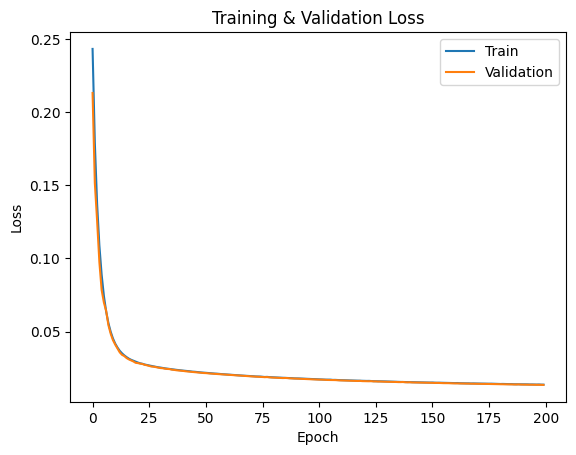

In [27]:
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

In [28]:
# Choose one test image for evaluation
test_idx = 1
sinogram, true_image_np = test_dataset[test_idx]
sinogram_np = sinogram.numpy()
true_image_np = true_image_np.numpy()

model.eval()

with torch.no_grad():

    #DeepPET
    inp = torch.from_numpy(sinogram_np).float().unsqueeze(0).unsqueeze(0).to(device)  # [1,1,H,W]
    out = model(inp)                                    # [1,1,H,W]
    image_dp = out.squeeze(0).squeeze(0).cpu().numpy()  # [H, W]
       
    mse = mean_squared_error(true_image_np, image_dp)
    ssim_val = ssim(true_image_np, image_dp, data_range=true_image_np.max() - true_image_np.min())

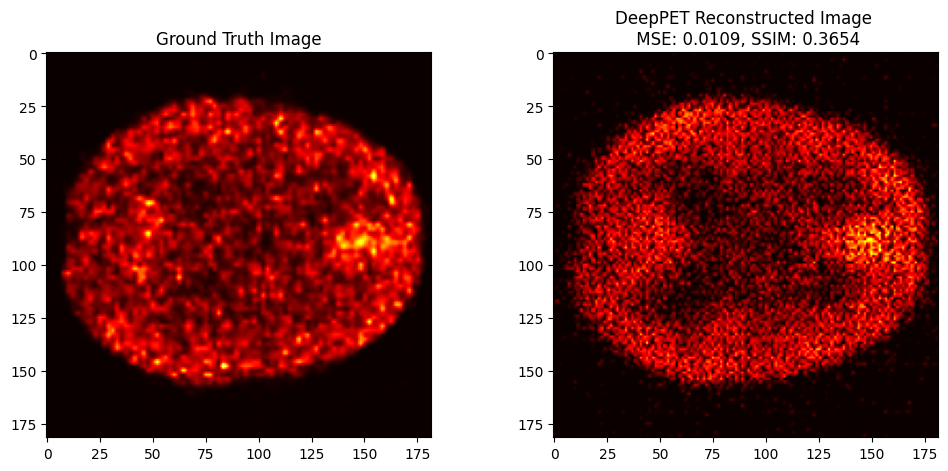

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

# MSE plot
axes[0].imshow(true_image_np, cmap="hot")
axes[0].set_title('Ground Truth Image')

# SSIM plot
axes[1].imshow(image_dp, cmap="hot")
axes[1].set_title(f'DeepPET Reconstructed Image \n MSE: {mse:.4f}, SSIM: {ssim_val:.4f}')
plt.show()

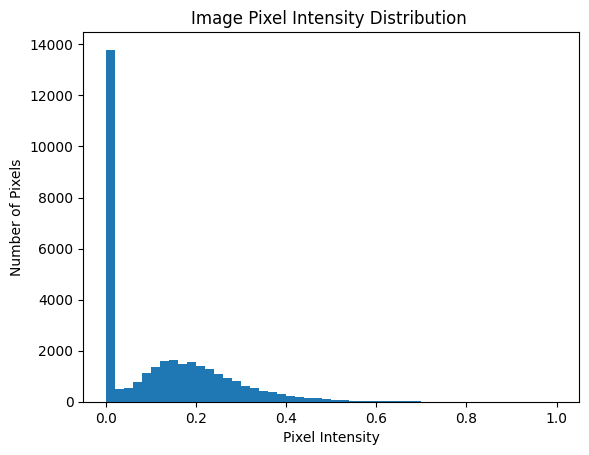

In [16]:
plt.hist(true_image_np.ravel(), bins=50)
plt.xlabel("Pixel Intensity")
plt.ylabel("Number of Pixels")
plt.title("Image Pixel Intensity Distribution ")
plt.show()

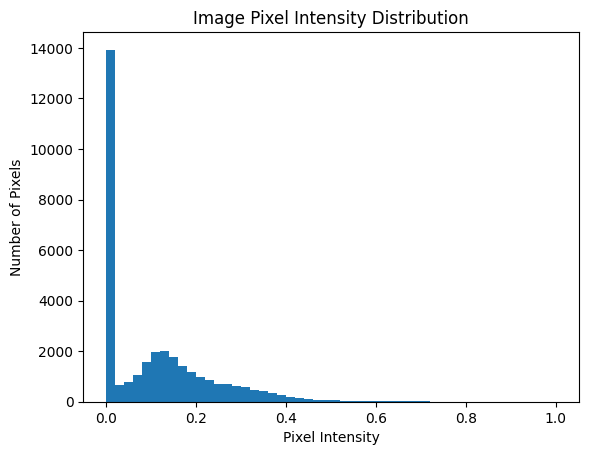

In [ ]:
plt.hist(image_dp.ravel(), bins=50)
plt.xlabel("Pixel Intensity")
plt.ylabel("Number of Pixels")
plt.title("Reconstructed Image Pixel Intensity Distribution")
plt.show()